# ngvs_intro.ipynb

### Isaac Cheng - September 2021

Just exploring the NGVS data (of VCC 792 aka NGC 4380) given to me. Read [this webpage](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/docs/ngvsdoc.html) for lots of useful information! Also look at [this PDF](https://www.ucolick.org/~bolte/AY257/s_n.pdf) for a useful overview of CCD signal/noise satistics. Also read the section on binning.

[Astropy Course](https://www.iasf-milano.inaf.it/astropy-course/), in particular, see the [Astropy image walkthrough](https://www.iasf-milano.inaf.it/AstropyCourse/07.Images.slides.html)

In [1]:
# # May need to do this if running remote server with VS Code
# %cd "/arc/home/IsaacCheng/coop_f2021/warmup"

/arc/home/IsaacCheng/coop_f2021/warmup


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import copy
%matplotlib widget

In [3]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.
    
    From https://stackoverflow.com/a/20528097.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


class MidPointLogNorm(LogNorm):
    """
    LogNorm with adjustable midpoint. From https://stackoverflow.com/a/48632237.
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)


## Log-Scale  1 Band Image & g-i Colour Index Image

In [4]:
def load_img(imgpath, idx=0):
    """
    Retrieves and returns the image data and header from a .fits file
    given a filepath.
    
    Parameters:
      imgpath :: str
        The path to the .fits file
      idx :: int (optional, default: 0)
        The index of the block from which to extract the data
    
    Returns: imgdata, imgheader, imgwcs
      imgdata :: 2D array
        An array with the pixel values from the .fits file
      imgheader :: `astropy.io.fits.header.Header`
        The header to the .fits file
    """
    with fits.open(imgpath) as hdu_list:
        hdu_list.info()
        # Get image data (typically in PRIMARY block)
        imgdata = hdu_list[idx].data  # 2D array
        # Get image header and WCS coordinates
        imgheader = hdu_list[idx].header
        # imgwcs = WCS(hdu_list[0].header)
    return imgdata, imgheader


def add_scalebar(ax, imgwcs, dist, scalebar_factor=1, label="1 kpc", color="k", loc="lower right",
                 size_vertical=0.5, pad=1, fontsize=12, **kwargs):
    """
    Adds a 1 kpc scale bar (by default) to a plot.
    
    Parameters:
      ax :: `matplotlib.axes._subplots.AxesSubplot`
        The matplotlib axis object on which to add the scalebar
      imgwcs :: `astropy.wcs.wcs.WCS`
        The WCS coordinates of the .fits file
      dist :: `astropy.units.quantity.Quantity` scalar
        The distance to the object
      scalebar_factor :: float
        Factor by which to multiply the 1 kpc scale bar.
      label :: str (optional, default: "1 kpc")
        The scale bar label
      color :: str (optional, default: "k")
        Colour of the scale bar and label
      loc :: str or int (optional, default: "lower right")
        The location of the scale bar and label
      size_vertical :: float (optional, default: 0.5)
        Vertical length of the scale bar (in ax units)
      pad :: float or int (optional, default: 1)
        Padding around scale bar and label (in fractions of the font size)
      fontsize :: str or int (optional, default: 12)
        The font size for the label
      **kwargs :: dict (optional)
        Keyworded arguments to pass to `matplotlib.offsetbox.AnchoredOffsetbox`
        
    Returns: ax.add_artist(scalebar)
      ax.add_artist(scalebar) :: `mpl_toolkits.axes_grid1.anchored_artists.AnchoredSizeBar`
        Adds the scale har to the given ax
    """
    arcsec_per_px = (proj_plane_pixel_scales(imgwcs.celestial)[0] * u.deg).to(u.arcsec)
    # Still deciding whether to use arctan for the next line
    arcsec_per_kpc = np.rad2deg(1 * u.kpc / dist.to(u.kpc) * u.rad).to(u.arcsec)
    px_per_kpc = arcsec_per_kpc / arcsec_per_px
    # Set font properties
    fontproperties = fm.FontProperties(size=fontsize)
    # Add scale bar
    scalebar = AnchoredSizeBar(ax.transData, px_per_kpc * scalebar_factor, label=label, loc=loc,
                               fontproperties=fontproperties, pad=pad, color=color,
                               frameon=False, size_vertical=size_vertical, **kwargs)
    return ax.add_artist(scalebar)


def plot_img_log(imgdata, imgheader, dist,
                 levels=18, cmap="magma", vmin=None, vmax=None, midpoint=None, interp="none",
                 scale_lbl="1 kpc", scale_loc="lower right", scale_color="k",
                 scalebar_factor=1, scale_size_vertical=0.5, scale_pad=1, scale_fontsize=12, 
                 fig_title=None, fig_yax=None, fig_xax=None, fig_cbar=None,
                 figname=None, dpi=300, **imshow_kwargs):
    """
    Plots an image with a spatial scale bar using `imshow` + a log_10 colour bar scale.
    Also optionally saves the figure if given a figname.
    May not use in the future since it is so clunky.
    
    FIXME: add **scale_kwargs
    
    Parameters:
      imgdata :: 2D array
        An array with the pixel values from the .fits file
      imgheader :: `astropy.io.fits.header.Header`
        The header to the .fits file
      dist :: `astropy.units.quantity.Quantity` scalar
        The distance to the object
      levels :: int (optional, default: 18. NOT USED)
        Number of contour levels to use (NOT USED)
      cmap :: str (optional, default: "magma")
        Colour map
      vmin, vmax, midpoint :: float (optional, defaults: None)
        The minimum, maximum, and midpoint of the colour bar. If None,
        use the default values determined by matplotlib
      interp :: str (optional, default: "none")
        Interpolation for `imshow` (e.g., "none", "antiasliased", "bicubic")
      scale_lbl, scale_loc, scale_color :: str (optional,
                                                defaults: "1 kpc", "lower right", "k")
        The label, location, and colour of the scale bar
      scalebar_factor :: float (optional, default: 1)
        Factor by which to multiply the 1 kpc scale bar.
      scale_size_vertical :: float (optional, default: 0.5)
        Vertical length of the scale bar (in axis units)
      scale_pad :: float or int (optional, default: 1)
        Padding around scale bar and label (in fractions of the font size)
      scale_fontsize :: str or int (optional, default: 12)
        The font size for the scale bar label
      fig_title, fig_yax, fig_xax, fig_cbar :: str (optional, defaults: None)
        The title of the plot, y-axis label, x-axis label, and colourbar label.
        If None, do not write labels (though astropy may automatically add coordinate labels)
      figname :: str (optional, default: None)
        Name of the file to save (e.g. "img.pdf", "img_2.png"). By default, it will save the file
        in the directory from which the Python file is called or where the iPython notebook is located.
        If None, do not save the image.
      dpi :: int (optional, default: 300)
        The dpi of the saved image. Relevant for raster graphics only (i.e., not PDFs).
      **imshow_kwargs :: dict (optional)
          Keyworded arguments to pass to `matplotlib.image.AxesImage`
    
      Returns: None
    """
    imgwcs = WCS(imgheader)
    # Remove background pixels
#     imgdata[imgdata <= 0] = np.nan  # or not. May look bad
#     imgdata[imgdata <= 0] = np.min(imgdata[imgdata > 0])
    imgdata[imgdata <= 0] = 1e-15
#     cmap = mpl.cm.get_cmap(cmap, levels)
    cmap = copy.copy(mpl.cm.get_cmap(cmap))
    # Set NaN pixels to lowest colour in colormap
    cmap.set_bad(cmap(0))
    #
    fig, ax = plt.subplots(subplot_kw={"projection": imgwcs})
    if midpoint is None:
        img = ax.imshow(imgdata, cmap=cmap,
                        norm=LogNorm(vmin=vmin, vmax=vmax),
                        interpolation=interp, **imshow_kwargs)
    elif midpoint > 0:
        img = ax.imshow(imgdata, cmap=cmap,
                        norm=MidPointLogNorm(vmin=vmin, vmax=vmax, midpoint=midpoint),
                        interpolation=interp, **imshow_kwargs)
    else:
        raise ValueError("midpoint should be >0 and between vmin & vmax")
    add_scalebar(ax, imgwcs, dist, scalebar_factor=scalebar_factor, label=scale_lbl,
                 color=scale_color, loc=scale_loc, size_vertical=scale_size_vertical,
                 pad=scale_pad, fontsize=scale_fontsize)
    cbar = fig.colorbar(img)
    cbar.ax.tick_params(which="both", direction="out")
    # cbar.ax.minorticks_off()
    cbar.set_label(fig_cbar) if fig_cbar is not None else None
    ax.tick_params(which="both", direction="out")
    ax.set_xlabel(fig_xax) if fig_xax is not None else None
    ax.set_ylabel(fig_yax) if fig_yax is not None else None
    ax.set_title(fig_title) if fig_title is not None else None
    ax.grid(False)
    ax.set_aspect("equal")
    fig.savefig(figname, bbox_inches="tight", dpi=dpi) if figname is not None else None
    plt.show()


def plot_img_linear(imgdata, imgheader, dist,
                    levels=18, cmap="magma", vmin=None, vmax=None, midpoint=0.5, interp="none",
                    scale_lbl="1 kpc", scale_loc="lower right", scale_color="k",
                    scalebar_factor=1, scale_size_vertical=0.5, scale_pad=1, scale_fontsize=12, 
                    fig_title=None, fig_yax=None, fig_xax=None, fig_cbar=None,
                    figname=None, dpi=300, **imshow_kwargs):
    """
    Plots an image with a spatial scale bar using `imshow` + a linear colour bar scale.
    Also optionally saves the figure if given a figname.
    May not use in the future since it is so clunky.
    
    FIXME: add **scale_kwargs
    
    Parameters:
      imgdata :: 2D array
        An array with the pixel values from the .fits file
      imgheader :: `astropy.io.fits.header.Header`
        The header to the .fits file
      dist :: `astropy.units.quantity.Quantity` scalar
        The distance to the object
      levels :: int (optional, default: 18. NOT USED)
        Number of contour levels to use (NOT USED)
      cmap :: str (optional, default: "magma")
        Colour map
      vmin, vmax, midpoint :: float (optional, defaults: None)
        The minimum, maximum of the colour bar. If None,
        use the default values determined by matplotlib
      midpoint :: float (optional, default: 0.5)
        The midpoint of the colourbar. Must be between 0.0 and 1.0.
      interp :: str (optional, default: "none")
        Interpolation for `imshow` (e.g., "none", "antiasliased", "bicubic")
      scale_lbl, scale_loc, scale_color :: str (optional,
                                                defaults: "1 kpc", "lower right", "k")
        The label, location, and colour of the scale bar
      scalebar_factor :: float (optional, default: 1)
        Factor by which to multiply the 1 kpc scale bar.
      scale_size_vertical :: float (optional, default: 0.5)
        Vertical length of the scale bar (in axis units)
      scale_pad :: float or int (optional, default: 1)
        Padding around scale bar and label (in fractions of the font size)
      scale_fontsize :: str or int (optional, default: 12)
        The font size for the scale bar label
      fig_title, fig_yax, fig_xax, fig_cbar :: str (optional, defaults: None)
        The title of the plot, y-axis label, x-axis label, and colourbar label.
        If None, do not write labels (though astropy may automatically add coordinate labels)
      figname :: str (optional, default: None)
        Name of the file to save (e.g. "img.pdf", "img_2.png"). By default, it will save the file
        in the directory from which the Python file is called or where the iPython notebook is located.
        If None, do not save the image.
      dpi :: int (optional, default: 300)
        The dpi of the saved image. Relevant for raster graphics only (i.e., not PDFs).
      **imshow_kwargs :: dict (optional)
          Keyworded arguments to pass to `matplotlib.image.AxesImage`
    
      Returns: None
    """
    imgwcs = WCS(imgheader)
    # Remove background pixels
#     imgdata[imgdata <= 0] = np.nan  # or not. May look bad
#     imgdata[imgdata <= 0] = np.min(imgdata[imgdata > 0])
#     imgdata[imgdata <= 0] = 1e-15
#     cmap = mpl.cm.get_cmap(cmap, levels)
    cmap = mpl.cm.get_cmap(cmap)
    cmap = copy.copy(shiftedColorMap(cmap, midpoint=midpoint))
    # Set NaN pixels to lowest colour in colormap
    cmap.set_bad(cmap(0))
    #
    fig, ax = plt.subplots(subplot_kw={"projection": imgwcs})
    img = ax.imshow(imgdata, cmap=cmap, vmin=vmin, vmax=vmax, **imshow_kwargs)
    add_scalebar(ax, imgwcs, dist, scalebar_factor=scalebar_factor, label=scale_lbl,
                 color=scale_color, loc=scale_loc, size_vertical=scale_size_vertical,
                 pad=scale_pad, fontsize=scale_fontsize)
    cbar = fig.colorbar(img)
    cbar.ax.tick_params(which="both", direction="out")
    # cbar.ax.minorticks_off()
    cbar.set_label(fig_cbar) if fig_cbar is not None else None
    ax.tick_params(which="both", direction="out")
    ax.set_xlabel(fig_xax) if fig_xax is not None else None
    ax.set_ylabel(fig_yax) if fig_yax is not None else None
    ax.set_title(fig_title) if fig_title is not None else None
    ax.grid(False)
    ax.set_aspect("equal")
    fig.savefig(figname, bbox_inches="tight", dpi=dpi) if figname is not None else None
    plt.show()

In [ ]:
def cutout(left=None, right=None, top=None, bottom=None):
    """
    Parameters:
      left, right, top, bottom :: int
        Indices for the left, right, top, and bottom
    """
    # TODO: make cutout method and also update the WCS object

### Log Image

In [4]:
vcc792_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
vcc792_dist = 16.5 * u.Mpc
data, header = load_img(vcc792_path)
plot_img_log(data, header, vcc792_dist, cmap="gray", vmin=1e-1, midpoint=23, vmax=None,
             scalebar_factor=10, scale_color="w", scale_lbl="10 kpc", fig_title="VCC 792 / NGC 4380",
             fig_yax="Dec (J2000)", fig_xax="RA (J2000)", fig_cbar="Log g-Band Flux", figname="vcc792_g_v1.pdf")

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### g-i Colour Index Image

In [5]:
vcc792_g_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
vcc792_i_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
data_g, header_g = load_img(vcc792_g_path)
data_i, header_i = load_img(vcc792_i_path)
# # Double-checking that the images have the same extent
# print(WCS(header_g).pixel_to_world(0,0))
# print(WCS(header_i).pixel_to_world(0,0))
# print(WCS(header_g).pixel_to_world(*data_g.shape))
# print(WCS(header_i).pixel_to_world(*data_i.shape))
plot_img_log(data_g, header_g, vcc792_dist, cmap="gray", vmin=1e-1, midpoint=23, vmax=None,
             scalebar_factor=10, scale_color="w", scale_lbl="10 kpc", fig_title="VCC 792 / NGC 4380",
             fig_yax="Dec (J2000)", fig_xax="RA (J2000)", fig_cbar="Log g-Band Flux")
plot_img_log(data_i, header_i, vcc792_dist, cmap="gray", vmin=1e-1, midpoint=23, vmax=None,
             scalebar_factor=10, scale_color="w", scale_lbl="10 kpc", fig_title="VCC 792 / NGC 4380",
             fig_yax="Dec (J2000)", fig_xax="RA (J2000)", fig_cbar="Log i-Band Flux")

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
gi_colour = -2.5 * np.log10(data_g / data_i)
# plt.hist(gi_colour.flatten(), bins=50)
# plt.show()
plot_img_linear(gi_colour, header_i, vcc792_dist, cmap="plasma", midpoint=0.5,
#                 vmin=np.percentile(gi_colour.flatten(), 22), vmax=np.percentile(gi_colour.flatten(), 83),
                vmin=0.5, vmax=1.6,
                interp="antialiased",
                scalebar_factor=10, scale_color="w", scale_size_vertical=20, scale_lbl="10 kpc", scale_fontsize=15,
                fig_title="VCC 792 / NGC 4380", fig_yax="Dec (J2000)", fig_xax="RA (J2000)",
                fig_cbar="g-i Colour Index", figname="vcc792_g-i_dpi300_v2.1.png")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
plt.close("all")

## RGB image

In [14]:
# "red" channel (i-band)
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
# "green" channel (g-band)
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
# "blue" channel (u-band)
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# 
# Load .fits files
# 
data_i, header_i = load_img(iband_path)
data_g, header_g = load_img(gband_path)
data_u, header_u = load_img(uband_path)

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   


### Direct data-to-RGB image

In [15]:
from astropy.visualization import make_lupton_rgb  # for RGB image. https://docs.astropy.org/en/stable/visualization/rgb.html
rgb_data = make_lupton_rgb(data_i, data_g, data_u)
rgb_wcs = WCS(header_i)
print(rgb_data.shape)

(3280, 5453, 3)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [16]:
vcc792_dist = 16.5 * u.Mpc
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs})
rgb_img = ax.imshow(rgb_data, interpolation="antialiased")
add_scalebar(ax, rgb_wcs, vcc792_dist, scalebar_factor=10, label="10 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
# fig.savefig("vcc792_rgb_noprocessing.png", dpi=300)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
# Cutout galaxy
from astropy.nddata import Cutout2D
data_i_cut = Cutout2D(data_i, (2716, 1613), (1100, 1300), wcs=rgb_wcs)
data_g_cut = Cutout2D(data_g, (2716, 1613), (1100, 1300), wcs=rgb_wcs).data
data_u_cut = Cutout2D(data_u, (2716, 1613), (1100, 1300), wcs=rgb_wcs).data
rgb_wcs_cut = data_i_cut.wcs
data_i_cut = data_i_cut.data

### Histogram Equalization (BAD)

In [54]:
from astropy.visualization import HistEqStretch  # for RGB image. https://docs.astropy.org/en/stable/visualization/rgb.html
data_i_histEq = HistEqStretch(data_i).data.reshape(data_i.shape)
data_g_histEq = HistEqStretch(data_g).data.reshape(data_g.shape)
data_u_histEq = HistEqStretch(data_u).data.reshape(data_u.shape)

In [58]:
rgb_data_histEq = make_lupton_rgb(data_i_histEq, data_g_histEq, data_u_histEq)
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs})
rgb_img = ax.imshow(rgb_data_histEq, interpolation="antialiased")
add_scalebar(ax, rgb_wcs, vcc792_dist, scalebar_factor=10, label="10 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
# fig.savefig("vcc792_rgb_histEq.png", dpi=300)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Normalizing image by exposure time

In [12]:
# Exposure times of each .fits file
print("i-band EXPTIME:", header_i["EXPTIME"])
print("g-band EXPTIME:", header_g["EXPTIME"])
print("u-band EXPTIME:", header_u["EXPTIME"])

i-band EXPTIME: 2055
g-band EXPTIME: 3170
u-band EXPTIME: 6402
6402


In [51]:
from astropy.visualization import LogStretch
vcc792_dist = 16.5 * u.Mpc
rgb_data_exp = []
max_exptime = np.max([header["EXPTIME"] for header in [header_i, header_g, header_u]])  # max exposure time
for image, header in zip([data_i_cut, data_g_cut, data_u_cut], [header_i, header_g, header_u]):   
    exptime = header["EXPTIME"]
    norm_factor = exptime / max_exptime  # if max_exptime / exptime, too red
    # Define transformation
    T = LogStretch(a=1000)
    # Apply transformation and create a new image
    image = image * norm_factor / 1000
    rgb_data_exp.append(T(image))
rgb_data_exp = np.dstack(rgb_data_exp)

In [52]:
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
ax.imshow(rgb_data_exp, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
# fig.savefig("vcc792_rgb_exptime_noLupton.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
vcc792_dist = 16.5 * u.Mpc
rgb_data_exp2 = []
max_exptime = np.max([header["EXPTIME"] for header in [header_i, header_g, header_u]])  # max exposure time
for image, header in zip([data_i_cut, data_g_cut, data_u_cut], [header_i, header_g, header_u]):   
    exptime = header["EXPTIME"]
    norm_factor = exptime / max_exptime  # if max_exptime / exptime, too red
    image = image * norm_factor
    rgb_data_exp2.append(image)
rgb_data_exp2 = np.dstack(rgb_data_exp2)
# 
rgb_data_exptime_lupton = make_lupton_rgb(rgb_data_exp2[:, :, 0], rgb_data_exp2[:, :, 1], rgb_data_exp2[:, :, 2], stretch=10)
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
ax.imshow(rgb_data_exptime_lupton, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
fig.savefig("vcc792_rgb_exptime_Lupton.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [71]:
# Dividing data by exposure time
vcc792_dist = 16.5 * u.Mpc
rgb_data_exp = []
for image, header in zip([data_i_cut, data_g_cut, data_u_cut], [header_i, header_g, header_u]):   
    exptime = header["EXPTIME"]
    # Define transformation
    T = LogStretch(a=1000)
    # Apply transformation and create a new image
    image = image / exptime
    rgb_data_exp.append(T(image))
rgb_data_exp = np.dstack(rgb_data_exp)

In [78]:
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
ax.imshow(rgb_data_exp, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
fig.savefig("vcc792_rgb_exptime_noLupton_v2.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [77]:
# Dividing data by exposure time
vcc792_dist = 16.5 * u.Mpc
rgb_data_exp2 = []
for image, header in zip([data_i_cut, data_g_cut, data_u_cut], [header_i, header_g, header_u]):   
    exptime = header["EXPTIME"]
    image = image / exptime * 100
    rgb_data_exp2.append(image)
rgb_data_exp2 = np.dstack(rgb_data_exp2)
# 
rgb_data_exptime_lupton = make_lupton_rgb(rgb_data_exp2[:, :, 0], rgb_data_exp2[:, :, 1], rgb_data_exp2[:, :, 2], stretch=10)
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
ax.imshow(rgb_data_exptime_lupton, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
fig.savefig("vcc792_rgb_exptime_Lupton_v2.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Normalizing image by median value

Manual recipe (without Lupton RGB)

In [10]:
# Adapted from https://www.iasf-milano.inaf.it/AstropyCourse/07.Images.slides.html#/21
from astropy.visualization import ManualInterval
rgb_data_med = []
for image in (data_i_cut, data_g_cut, data_u_cut):   
    median = np.median(image.data)
    delta = (image.max() - median) / 25
    high = median + delta
    low = median - delta / 10
    # Define transformation
    T = ManualInterval(low, high)
    # Apply transformation and create a new image
    rgb_data_med.append(T(image))
rgb_data_med = np.dstack(rgb_data_med)

In [133]:
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
ax.imshow(rgb_data_med, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
fig.savefig("vcc792_rgb_med_noLupton_v1.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [220]:
# Trying another median normalization scheme
rgb_data_med2 = []
max_flux_all = np.max([data_i_cut.data, data_g_cut.data, data_u_cut.data]).max()
for image in (data_i_cut, data_g_cut, data_u_cut):   
    median = np.median(image.data)
    delta = (max_flux_all - median)
    high = median + delta  # max_flux_all
    low = median - delta / 15
    # Define transformation
    T = ManualInterval(low, high)
    # Apply transformation and create a new image
    image = image / median * 130
    rgb_data_med2.append(T(image))
rgb_data_med2 = np.dstack(rgb_data_med2)
# 
# Plot
# 
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
# fig, ax = plt.subplots()
ax.imshow(rgb_data_med2, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
# fig.savefig("vcc792_rgb_med_noLupton_v2.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [47]:
# v2 but using log scaling (v2.1)
vcc792_dist = 16.5 * u.Mpc
from astropy.visualization import LogStretch
rgb_data_med2 = []
for image in (data_i_cut, data_g_cut, data_u_cut):
    median = np.median(image.data)
    # Define transformation
    T = LogStretch(a=1000)
    # Apply transformation and create a new image
    image = image / median / 1000
    rgb_data_med2.append(T(image))
rgb_data_med2 = np.dstack(rgb_data_med2)
# 
# Plot
# 
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
# fig, ax = plt.subplots()
ax.imshow(rgb_data_med2, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
fig.savefig("vcc792_rgb_med_noLupton_v2.1.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [217]:
# Trying yet another median normalization scheme. This time apply diff
# normalization scheme to galactic centre vs. rest of disk
rgb_data_med3 = []
max_flux_all = np.max([data_i_cut.data, data_g_cut.data, data_u_cut.data]).max()
for image in (data_i_cut, data_g_cut, data_u_cut):   
    median = np.median(image.data)
    delta = (max_flux_all - median)
    high = median + delta  # max_flux_all
    low = median - delta / 15
    # Define transformation
    T = ManualInterval(low, high)
    # Apply transformation and create a new image
    image = image / median * 130
    print(image.shape)
    # Decrease brightness of galactic centre
    image[519:624, 614:700] = image[519:624, 614:700] / 10
    # TODO: np.average with Gaussian weights
    rgb_data_med3.append(T(image))
rgb_data_med3 = np.dstack(rgb_data_med3)
# 
# Plot
# 
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
ax.imshow(rgb_data_med3, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
fig.savefig("vcc792_rgb_med_noLupton_v3_bad.pdf")
plt.show()

(1100, 1300)
(1100, 1300)
(1100, 1300)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Median normalization with Lupton RGB

In [124]:
print(rgb_data_med[:, :, 0].shape)

(1100, 1300)


In [39]:
# rgb_data_med_lupton = make_lupton_rgb(rgb_data_med[:, :, 0], rgb_data_med[:, :, 1], rgb_data_med[:, :, 2])
rgb_data_med_lupton = make_lupton_rgb(data_i_cut / np.median(data_i_cut), data_g_cut / np.median(data_g_cut), data_u_cut / np.median(data_u_cut),
                                     stretch=10)
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
ax.imshow(rgb_data_med_lupton, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
# fig.savefig("vcc792_rgb_med_Lupton.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:
plt.close("all")

## Contour Overlay on Various Colour Index Maps


In [5]:
from astropy.nddata import Cutout2D
# "red" channel (i-band)
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
# "green" channel (g-band)
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
# "blue" channel (u-band)
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# 
# Load .fits files
# 
data_i, header_i = load_img(iband_path)
data_g, header_g = load_img(gband_path)
data_u, header_u = load_img(uband_path)
colouridx_wcs = WCS(header_i)
# 
# Cutout galaxy
# 
data_i_cut = Cutout2D(data_i, (2716, 1613), (1480, 1127), wcs=colouridx_wcs)
data_g_cut = Cutout2D(data_g, (2716, 1613), (1480, 1127), wcs=colouridx_wcs).data
data_u_cut = Cutout2D(data_u, (2716, 1613), (1480, 1127), wcs=colouridx_wcs).data
colouridx_wcs_cut = data_i_cut.wcs
data_i_cut = data_i_cut.data

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [6]:
# VERTICO CO Data
co_path = "/arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits"
data_co, header_co = load_img(co_path)

Filename: /arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (78, 78)   float64   


### g-i Colour


In [8]:
gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)
vcc792_dist = 16.5 * u.Mpc
cmap = "plasma_r"
cmap = mpl.cm.get_cmap(cmap)
cmap = copy.copy(shiftedColorMap(cmap, midpoint=0.5))
# cmap.set_bad(cmap(0))
cmap.set_bad("w")
#
fig, ax = plt.subplots(subplot_kw={"projection": colouridx_wcs_cut})
# fig, ax = plt.subplots()
img = ax.imshow(gi_colour, cmap=cmap, vmin=0.5, vmax=1.6)
add_scalebar(ax, colouridx_wcs_cut, vcc792_dist,
             scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
# cbar.ax.minorticks_off()
cbar.set_label("g-i Colour Index")
cbar.ax.invert_yaxis()  # since negative magnitude = brighter
# 
# Overplot CO contours from VERTICO data
# 
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)),
           levels=0,
        #    levels=range(18, 2),
           colors='w')
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
ax.grid(False)
ax.set_aspect("equal")
fig.savefig("imgs/vcc792_contour1_g-i.pdf")
plt.show()


<ipython-input-8-88df9164f2de>:1: RuntimeWarning: invalid value encountered in log10
  gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


### u-g Colour


In [9]:
ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)
vcc792_dist = 16.5 * u.Mpc
cmap = "plasma_r"
cmap = mpl.cm.get_cmap(cmap)
cmap = copy.copy(shiftedColorMap(cmap, midpoint=0.5))
# cmap.set_bad(cmap(0))
cmap.set_bad("w")
#
fig, ax = plt.subplots(subplot_kw={"projection": colouridx_wcs_cut})
# fig, ax = plt.subplots()
img = ax.imshow(ug_colour, cmap=cmap, vmin=0.5, vmax=1.6)
add_scalebar(ax, colouridx_wcs_cut, vcc792_dist,
             scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
# cbar.ax.minorticks_off()
cbar.set_label("u-g Colour Index")
cbar.ax.invert_yaxis()  # since negative magnitude = brighter
# 
# Overplot CO contours from VERTICO data
# 
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)),
           levels=0,
        #    levels=range(18, 2),
           colors='w')
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
ax.grid(False)
ax.set_aspect("equal")
fig.savefig("imgs/vcc792_contour1_u-g.pdf")
plt.show()

<ipython-input-9-e8daa1e85cd5>:1: RuntimeWarning: invalid value encountered in log10
  ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


### u-i Colour

In [10]:
ui_colour = -2.5 * np.log10(data_u_cut / data_i_cut)
vcc792_dist = 16.5 * u.Mpc
cmap = "plasma_r"
cmap = mpl.cm.get_cmap(cmap)
cmap = copy.copy(shiftedColorMap(cmap, midpoint=0.5))
# cmap.set_bad(cmap(0))
cmap.set_bad("w")
#
fig, ax = plt.subplots(subplot_kw={"projection": colouridx_wcs_cut})
# fig, ax = plt.subplots()
img = ax.imshow(ui_colour, cmap=cmap, vmin=1.2, vmax=2.5)
add_scalebar(ax, colouridx_wcs_cut, vcc792_dist,
             scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
# cbar.ax.minorticks_off()
cbar.set_label("u-i Colour Index")
cbar.ax.invert_yaxis()  # since negative magnitude = brighter
# 
# Overplot CO contours from VERTICO data
# 
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)),
           levels=0,
        #    levels=range(18, 2),
           colors='w')
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
ax.grid(False)
ax.set_aspect("equal")
fig.savefig("imgs/vcc792_contour1_u-i.pdf")
# plt.show()

<ipython-input-10-ee1dd7164297>:1: RuntimeWarning: invalid value encountered in log10
  ui_colour = -2.5 * np.log10(data_u_cut / data_i_cut)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


In [70]:
plt.close("all")

## Contour Overlay on RGB Map


In [11]:
from astropy.nddata import Cutout2D
# "red" channel (i-band)
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
# "green" channel (g-band)
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
# "blue" channel (u-band)
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"

# Load .fits files
# 
data_i, header_i = load_img(iband_path)
data_g, header_g = load_img(gband_path)
data_u, header_u = load_img(uband_path)
rgb_wcs = WCS(header_i)
# 
# Cutout galaxy
# 
# (2716, 1613), (1100, 1300)
data_i_cut = Cutout2D(data_i, (2716, 1613), (1100, 1300), wcs=rgb_wcs)
data_g_cut = Cutout2D(data_g, (2716, 1613), (1100, 1300), wcs=rgb_wcs).data
data_u_cut = Cutout2D(data_u, (2716, 1613), (1100, 1300), wcs=rgb_wcs).data
rgb_wcs_cut = data_i_cut.wcs
data_i_cut = data_i_cut.data

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [12]:
from astropy.visualization import LogStretch
vcc792_dist = 16.5 * u.Mpc
rgb_data_med2 = []
for image in (data_i_cut, data_g_cut, data_u_cut):
    median = np.median(image.data)
    # Define transformation
    T = LogStretch(a=1000)
    # Apply transformation and create a new image
    image = image / median / 1000
    rgb_data_med2.append(T(image))
rgb_data_med2 = np.dstack(rgb_data_med2)
# 
# Plot
# 
fig, ax = plt.subplots(subplot_kw={"projection": rgb_wcs_cut})
# fig, ax = plt.subplots()
ax.imshow(rgb_data_med2, interpolation="none")
add_scalebar(ax, rgb_wcs_cut, vcc792_dist, scalebar_factor=2, label="2 kpc", color="w")
# 
# Overplot CO contours from VERTICO data
# 
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)),
           levels=0,
        #    levels=range(18, 2),
           colors='w')
ax.grid(False)
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
fig.savefig("imgs/vcc792_contour1_rgb.pdf")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


In [17]:
plt.close("all")

## Major Axis Colour Profile of VCC 792


### Testing Method


In [59]:
def line_profile(data, start, end):
    """
    Returns the profile of some 2D data along a line specified by the start and end
    points. Uses very rough nearest-neighbour sampling.
    
    Parameters:
      data :: 2D array
        The data to be profiled
      start :: 2-tuple of int
        (x, y) pixel coordinates of the start point
      end :: 2-tuple of int
        (x, y) pixel coordinates of the end point
        
    Returns: profile
      profile :: 1D array
        The line profile of the data
    """
    x0, y0 = start
    x1, y1 = end
    length = int(np.sqrt((x1 - x0)**2 + (y1 - y0)**2))
    x_idx = np.linspace(x0, x1, length).astype(int)
    y_idx = np.linspace(y0, y1, length).astype(int)
    profile = data[y_idx, x_idx]  # array indexing is [row, col]
    return profile
    

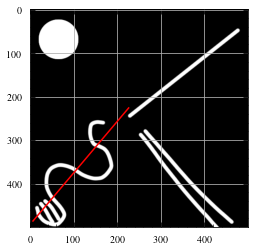

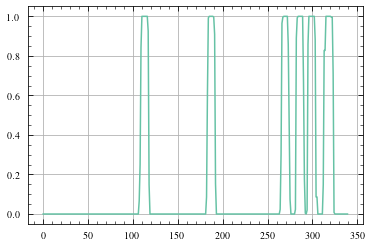

In [129]:
%matplotlib inline
# Load test image
test_img = plt.imread("test_interp.png")
# plt.imshow(test_img[:, :, 0])
plt.imshow(test_img)
# test_start, test_end = (227, 245), (475, 48)
test_start, test_end = (226, 226), (6, 486)
plt.plot([test_start[0], test_end[0]], [test_start[1], test_end[1]], "r-")
plt.show()
test_profile = line_profile(test_img, test_start, test_end)
# print(test_profile.shape)
# print(test_profile[:, 0])
plt.plot(test_profile[:, 0])
plt.show()

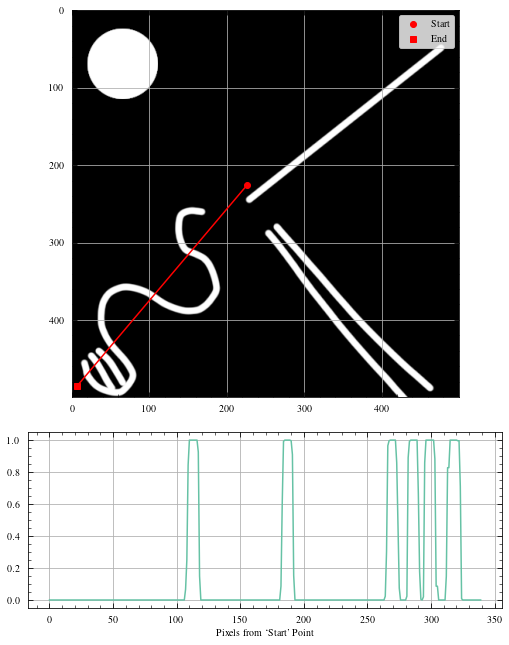

In [140]:
test_start, test_end = (226, 226), (6, 486)
test_profile = line_profile(test_img, test_start, test_end)
# fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={"height_ratios": [2, 1]})
fig = plt.figure(figsize=(8.5, 11))
ax1 = fig.add_subplot(3, 1, (1, 2))
ax1.imshow(test_img)
ax1.plot([test_start[0], test_end[0]], [test_start[1], test_end[1]], "r-")
ax1.plot(*test_start, "ro", label="Start")
ax1.plot(*test_end, "rs", label="End")
ax1.legend(loc="upper right")
ax2 = fig.add_subplot(3, 1, 3)
ax2.plot(test_profile[:, 0])
ax2.set_xlabel("Pixels from `Start' Point")
fig.savefig("test_majAxProfile.pdf")
plt.show()

### u-g Colour Profile

In [76]:
from astropy.nddata import Cutout2D
# "red" channel (i-band)
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
# "green" channel (g-band)
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
# "blue" channel (u-band)
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# 
# Load .fits files
# 
data_i, header_i = load_img(iband_path)
data_g, header_g = load_img(gband_path)
data_u, header_u = load_img(uband_path)
colouridx_wcs = WCS(header_i)
# 
# Cutout galaxy
# 
data_i_cut = Cutout2D(data_i, (2716, 1613), (1480, 1127), wcs=colouridx_wcs)
data_g_cut = Cutout2D(data_g, (2716, 1613), (1480, 1127), wcs=colouridx_wcs).data
data_u_cut = Cutout2D(data_u, (2716, 1613), (1480, 1127), wcs=colouridx_wcs).data
colouridx_wcs_cut = data_i_cut.wcs
data_i_cut = data_i_cut.data
# 
# VERTICO CO Data
# 
co_path = "/arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits"
data_co, header_co = load_img(co_path)

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      63   (78, 78)   float64   


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [151]:
%matplotlib widget
ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)
vcc792_dist = 16.5 * u.Mpc
cmap = "plasma_r"
cmap = mpl.cm.get_cmap(cmap)
cmap = copy.copy(shiftedColorMap(cmap, midpoint=0.5))
cmap.set_bad("w")
#
fig, ax = plt.subplots(subplot_kw={"projection": colouridx_wcs_cut})
# fig, ax = plt.subplots()
img = ax.imshow(ug_colour, cmap=cmap, vmin=0.5, vmax=1.6)
add_scalebar(ax, colouridx_wcs_cut, vcc792_dist,
             scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("u-g Colour Index")
cbar.ax.invert_yaxis()  # since negative magnitude = brighter
# 
# Overplot CO contours from VERTICO data
# 
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
#
# Plot line showing major axis
# 
ug_start, ug_end = (350, 358), (811, 1157)
ax.plot([ug_start[0], ug_end[0]], [ug_start[1], ug_end[1]], "c-")
# ax.text(*ug_start, "Start", color="c")
# ax.text(*ug_end, "End", color="c")
ax.plot(*ug_start, "co", label="Start")
ax.plot(*ug_end, "cs", label="End")
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
ax.grid(False)
ax.set_aspect("equal")
ax.legend(loc="lower right")
plt.show()
# 
# Get major axis profile
# 
ug_profile = line_profile(ug_colour, ug_start, ug_end)
fig, ax = plt.subplots()
ax.plot(ug_profile)
ax.invert_yaxis()
ax.set_ylabel("u-g Colour Index")
ax.set_xlabel("Pixels from 'Start' Point")
ax.set_title("VCC 792 / NGC 4380: Major Axis Colour Profile")
plt.show()

<ipython-input-151-a2afaed1335d>:2: RuntimeWarning: invalid value encountered in log10
  ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-139-27100785016c>:3: RuntimeWarning: invalid value encountered in log10
  ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)
/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


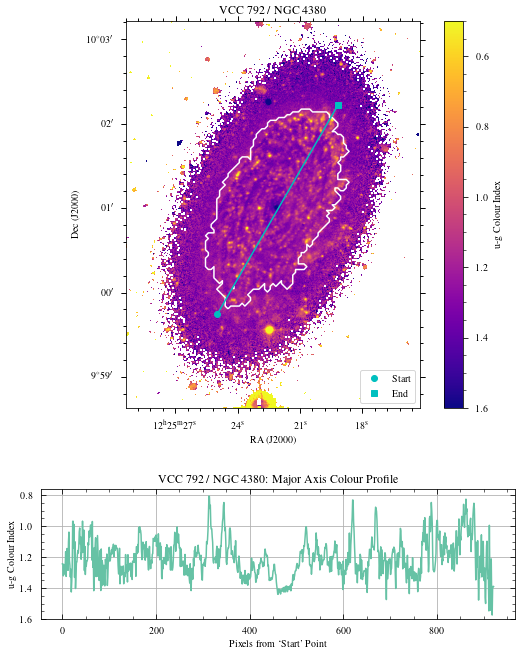

In [139]:
# Major axis u-g colour profile (2 subplots)
%matplotlib inline
ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)
vcc792_dist = 16.5 * u.Mpc
cmap = "plasma_r"
cmap = mpl.cm.get_cmap(cmap)
cmap = copy.copy(shiftedColorMap(cmap, midpoint=0.5))
cmap.set_bad("w")
#
fig = plt.figure(figsize=(8.5, 11))
ax = fig.add_subplot(3, 1, (1, 2), projection=colouridx_wcs_cut)
img = ax.imshow(ug_colour, cmap=cmap, vmin=0.5, vmax=1.6)
add_scalebar(ax, colouridx_wcs_cut, vcc792_dist,
             scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("u-g Colour Index")
cbar.ax.invert_yaxis()  # since negative magnitude = brighter
# 
# Overplot CO contour from VERTICO data
# 
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)),
           levels=0,
           colors='w')
# 
# Plot line showing major axis
# 
ug_start, ug_end = (350, 358), (811, 1157)
ax.plot([ug_start[0], ug_end[0]], [ug_start[1], ug_end[1]], "c-")
ax.plot(*ug_start, "co", label="Start")
ax.plot(*ug_end, "cs", label="End")
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
ax.grid(False)
ax.set_aspect("equal")
ax.legend(loc="lower right")
# 
# Get major axis profile
# 
ug_profile = line_profile(ug_colour, ug_start, ug_end)
ax2 = fig.add_subplot(414)
ax2.plot(ug_profile)
ax2.invert_yaxis()
ax2.set_ylim(1.6, 0.76)
ax2.set_ylabel("u-g Colour Index")
ax2.set_xlabel("Pixels from `Start' Point")
ax2.set_title("VCC 792 / NGC 4380: Major Axis Colour Profile")
fig.savefig("imgs/vcc792_majAxProfile.pdf")
plt.show()

In [182]:
def line_profile_idx(data, start, end):
    """
    Returns the profile of some 2D data along a line specified by the start and end
    points. Also returns the x and y pixel indices of the line. Uses
    very rough nearest-neighbour sampling.
    
    Parameters:
      data :: 2D array
        The data to be profiled
      start :: 2-tuple of int
        (x, y) pixel coordinates of the start point
      end :: 2-tuple of int
        (x, y) pixel coordinates of the end point

    Returns: profile
      profile :: 1D array
        The line profile of the data
      x_idx, y_idx :: 1D arrays
        The pixel coordinates of the line
    """
    x0, y0 = start
    x1, y1 = end
    length = int(np.sqrt((x1 - x0)**2 + (y1 - y0)**2))
    x_idx = np.linspace(x0, x1, length).astype(int)
    y_idx = np.linspace(y0, y1, length).astype(int)
    profile = data[y_idx, x_idx]  # array indexing is [row, col]
    return profile, x_idx, y_idx

<ipython-input-188-6065a4a1760c>:4: RuntimeWarning: invalid value encountered in log10
  ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)
/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


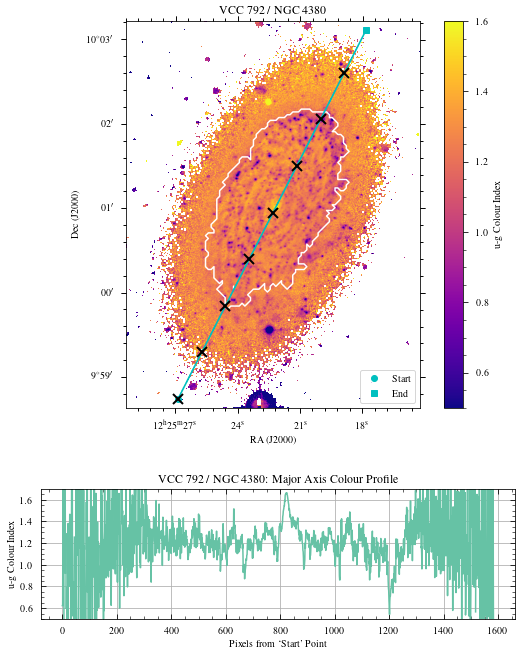

In [188]:
# Major axis u-g colour profile (2 subplots, extended line and added line ticks)
%matplotlib inline
ug_colour = -2.5 * np.log10(data_u_cut / data_g_cut)
vcc792_dist = 16.5 * u.Mpc
cmap = "plasma"
cmap = mpl.cm.get_cmap(cmap)
cmap = copy.copy(shiftedColorMap(cmap, midpoint=0.5))
cmap.set_bad("w")
#
fig = plt.figure(figsize=(8.5, 11))
ax = fig.add_subplot(3, 1, (1, 2), projection=colouridx_wcs_cut)
img = ax.imshow(ug_colour, cmap=cmap, vmin=0.5, vmax=1.6)
add_scalebar(ax, colouridx_wcs_cut, vcc792_dist,
             scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("u-g Colour Index")
# cbar.ax.invert_yaxis()  # since negative magnitude = brighter
# 
# Overplot CO contour from VERTICO data
# 
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)),
           levels=0,
           colors='w')
# 
# Plot line showing major axis
# 
ug_start, ug_end = (200, 34), (920, 1446)
ug_profile, ug_xs, ug_ys = line_profile_idx(ug_colour, ug_start, ug_end)
# ax.plot([ug_start[0], ug_end[0]], [ug_start[1], ug_end[1]], "c-")
ax.plot(ug_xs, ug_ys, "c-")
ax.plot(*ug_start, "co", label="Start")
ax.plot(*ug_end, "cs", label="End")
# 
# Tick marks along line
# 
ax.plot(ug_xs[::200], ug_ys[::200], "kx", markersize=10, markeredgewidth=2, zorder=10)
# 
# Other plot parameters
# 
ax.tick_params(which="both", direction="out")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380")
ax.grid(False)
ax.set_aspect("equal")
ax.legend(loc="lower right")
# 
# Plot major axis profile
# 
ax2 = fig.add_subplot(414)
ax2.plot(ug_profile)
# ax2.invert_yaxis()
ax2.set_ylim(0.5, 1.7)
ax2.set_ylabel("u-g Colour Index")
ax2.set_xlabel("Pixels from `Start' Point")
ax2.set_title("VCC 792 / NGC 4380: Major Axis Colour Profile")
fig.savefig("imgs/vcc792_majAxProfile_v2_lim.pdf")
plt.show()

In [147]:
plt.close("all")